# Xilium IA

> FA2 | BARKER, OUALI, GUILLERAY, GRAVIER, LEMOUTON  

## Introduction

Xilium est une application de ticketing qui permet au personnel de créer des tickets si ils ont des problèmes informatiques que des techniciens pourront résoudre si besoin. Le membre du personnel va donc attribuer une catégorie à son ticket pour qu'il soit plus facilement triable et traitable. Cependant, les techniciens et les administrateurs peuvent adapter le champ de catégorie en fonction de leur préférence pour qu'il corresponde réellement au problème posé. Pour cela, nous avons créé une IA qui va, à partir de la description du ticket, déterminer sa catégorie et en proposer une potentiellement plus pertinente. Si la catégorie determinée par l'IA est la même que celle déjà indiquée dans le ticket, alors rien ne change. Si la catégorie proposée est différente, le technicien ou l'administrateur peut valider la suggestion de l'IA et avoir une catégorie pertinente pour le ticket.
 

## Le programme
### Import des librairies


In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Lecture du csv et creation des sets

In [82]:
df = pd.read_csv("./src/app/ai/data/tickets.csv")
X = df.description
y = df.categorie
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [83]:
df

,type,description,priorite,categorie
0,Demande,Impossible d'ouvrir le projet dans l'IDE,Elevé,Logiciel
1,Incident,Le serveur de développement est inaccessible,Moyenne,Réseau
2,Demande,Nouvelle fonctionnalité pour le système de ges...,Faible,Logiciel
3,Incident,Le matériel de développement est défectueux,Elevé,Matériel
4,Demande,Ajout d'un nouveau chapitre dans la documentation,Faible,Documentation
...,...,...,...,...
547,Demande,Ajouter des ressources pour les étudiants étra...,Moyenne,Documentation
548,Incident,La documentation de Apache Flink est introuvable,Élevée,Documentation
549,Demande,Créer un guide de démarrage rapide pour les no...,Basse,Documentation
550,Incident,La documentation de Apache Spark est erronée,Haute,Documentation


In [84]:
df.categorie.value_counts()

categorie
Logiciel         138
Réseau           138
Matériel         138
Documentation    138
Name: count, dtype: int64

On peut voir que les données sont bien réparties dans les différentes catégories. On peut donc commencer à travailler sur les données.

### Création du pipeline et du GridSearch pour fit les données puis les prédire

In [85]:
pip = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("model", LogisticRegression(class_weight='balanced', max_iter=1000)) # On fait une regression logistique équlibré avec nos données
])
parameters = {"tfidf__ngram_range": [(1, 1), (1, 2)],
              "model__C": np.logspace(-2, 2, 5)}
gs = GridSearchCV(pip, parameters, verbose=1)
gs.fit(X_train, y_train) # On fit les données, c'est a dire qu'on creer le modèle pour pouvoir prédire des données
y_test_pred = gs.predict(X_test) # On prédit les données de test

Fitting 5 folds for each of 10 candidates, totalling 50 fits


### Rapport de classification 

La partie suivante génère un rapport de classification pour voir les performances de notre modèle. 

In [86]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

Documentation       1.00      1.00      1.00        43
     Logiciel       1.00      1.00      1.00        35
     Matériel       0.96      1.00      0.98        26
       Réseau       1.00      0.97      0.99        34

     accuracy                           0.99       138
    macro avg       0.99      0.99      0.99       138
 weighted avg       0.99      0.99      0.99       138



Le rapport de classification comporte plusieurs données, dont :
- La précision : elle mesure la proportion de prédictions positives correctes parmi toutes les prédictions positives effectuées par le modèle. Elle est utile lorsque le coût des faux positifs est élevé.
- Le rappel : il mesure la proportion de prédictions positives correctes parmi toutes les instances réellement positives. Il est utile lorsque le coût des faux négatifs est élevé ou qu'il est important de détecter toutes les instances positives.
- Le f1-score : il est la moyenne harmonique de la précision et du rappel. C'est une métrique utile lorsqu'on souhaite avoir un compromis entre la précision et le rappel.
- Le support : il est le nombre d'occurrences de chaque classe dans l'ensemble de données.


Sur notre modèle, on remarque que la précision, le rappel et le f1-score sont très bons. On peut donc dire que notre modèle est performant.

Il est possible de modéliser avec une heatmap la matrice de confusion pour voir les erreurs de classification.


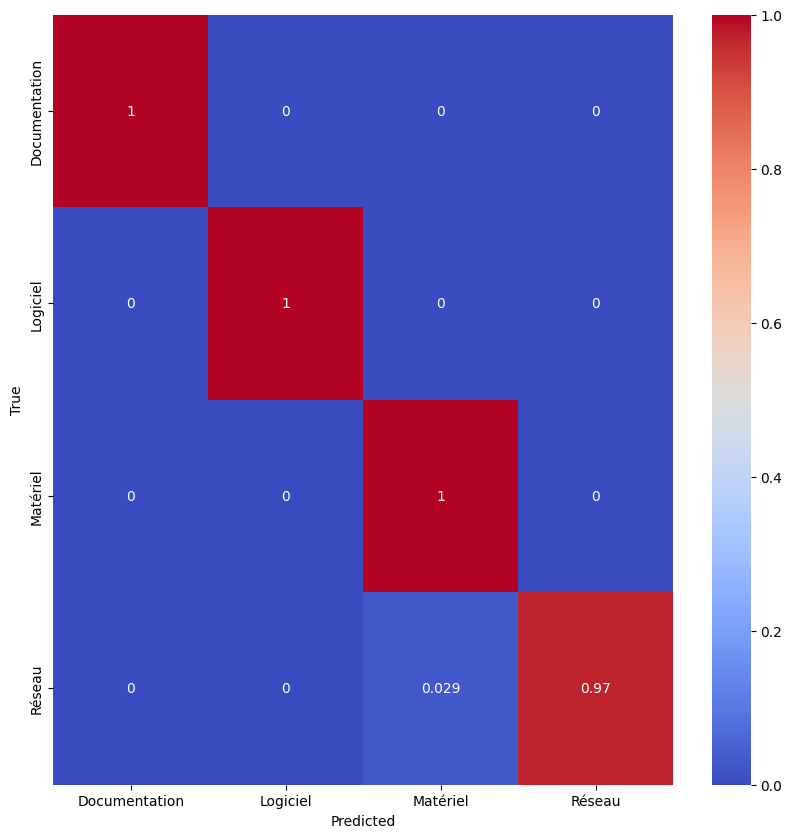

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

sns.heatmap(pd.crosstab(y_test, y_test_pred, normalize='index', rownames=['True'], colnames=['Predicted']), annot=True, cmap="coolwarm")
plt.show()